In [1]:
import pandas as pd
import numpy as np
import requests

In [2]:
import matplotlib.pyplot as plt

In [3]:
#query data from a particular state (admin1:'state'), when fetchall = True
def query_state(state):
    https_address = "https://api.outbreak.info/covid19/query?q=admin1:" + state + '&fetch_all=True'
    state_req = requests.get(https_address)
    scroll_address = "https://api.outbreak.info/covid19/query?scroll_id="
    scroll_id = state_req.json()['_scroll_id']
    scroll_df = pd.DataFrame(columns = pd.Series(state_req.json()['hits'][0]).index)
    
    while len(scroll_df) <= 2000:
        data = state_req.json()['hits']
        #individual request df
        base_df = pd.DataFrame(columns = scroll_df.columns)
        for i in range(len(data)):
            data[i] = pd.Series(data[i], name = i)
            base_df = base_df.append(data[i], ignore_index=True)
        #reset scroll_id based on current scroll 
        scroll_id = state_req.json()['_scroll_id']
        to_scroll = scroll_address + scroll_id
        state_req = requests.get(to_scroll)
        scroll_df = scroll_df.append(base_df, ignore_index=True)
    #applying datetime to dates column and sorting in ascending 
    scroll_df['date'] = scroll_df['date'].apply(lambda x: pd.to_datetime(x))
    scroll_df = scroll_df.sort_values(by='date', ascending=True)
    scroll_df.reset_index(drop=True,inplace=True)
    return scroll_df

In [4]:
colorado = query_state("Colorado")

In [5]:
washington = query_state("Washington")
minnesota = query_state("Minnesota")
louisiana = query_state('Louisiana')

In [6]:
#combining colorado/washington/minnesota/louisiana into a merged df and writing it to csv
wild_states = pd.concat([colorado, washington, minnesota, louisiana], axis = 0)

In [7]:
wild_states.to_csv('wild_states_epi.csv', index=False)

## Exploratory Data Analysis

In [8]:
#grouping by statistical areas to check if we have redundant observations
FIPS_grouped_data = wild_states.groupby('FIPS')
stats = {'confirmed_unique':[], 'FIPS_group':[], 'group_size': [], 'perc_nonunique': []}
for group, data in FIPS_grouped_data:
    unique_confirmed = len(data['confirmed_per_100k'].unique())
    stats['confirmed_unique'].append(unique_confirmed)
    stats['FIPS_group'].append(group)
    stats['group_size'].append(len(data))
    stats['perc_nonunique'].append(1 - (unique_confirmed / len(data)))

In [9]:
stats = pd.DataFrame(stats)

In [10]:
stats.sort_values(by='perc_nonunique', ascending=False, inplace=True)

In [11]:
nonunique_bins = pd.qcut(stats['perc_nonunique'],4)

In [12]:
nonunique_viz = pd.DataFrame({'perc_nonunique': stats['perc_nonunique'], 'bin': nonunique_bins})

In [13]:
barh_nonunique = nonunique_viz.groupby('bin').apply(len)

In [14]:
normalized_nonunique = barh_nonunique / sum(barh_nonunique)

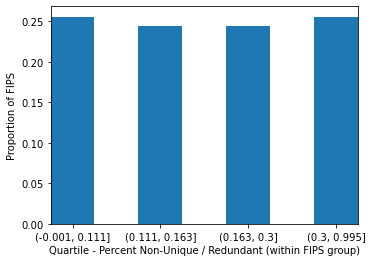

In [15]:
#visualizing the uniqueness of the entries
fig = plt.bar([str(x) for x in normalized_nonunique.index], normalized_nonunique, width = 0.5)
#align the x-axis to read all labels
plt.gca().margins(x=0)
plt.gcf().canvas.draw()
tl = plt.gca().get_xticklabels()
maxsize = max([t.get_window_extent().width for t in tl])
m = 0.2 # inch margin
N = len(barh_nonunique)
s = maxsize/plt.gcf().dpi*N+2*m
margin = m/plt.gcf().get_size_inches()[0]

plt.gcf().subplots_adjust(left=margin, right=1.-margin)
plt.gcf().set_size_inches(s, plt.gcf().get_size_inches()[1])

plt.xlabel('Quartile - Percent Non-Unique / Redundant (within FIPS group)')
plt.ylabel('Proportion of FIPS')
plt.show()

Since the majority (>70%) of FIPS / Federal Information Processing Series Codes (geographic place codes) have a low non-unique  number (redundancy) of confirmed positive covid cases per 100k of < 29%, I assume that the data is mostly NOT redundant. 

In [16]:
no_reported_cases = wild_states.where(wild_states['confirmed_per_100k'] == 0).dropna(how='all')

In [17]:
num_zero = {'FIPS_group': [], 'num_zero': []}
for fips, data in no_reported_cases.groupby('FIPS'):
    num_zero['FIPS_group'].append(fips)
    num_zero['num_zero'].append(len(data))
    

In [18]:
zero_cases = pd.DataFrame(num_zero)

In [19]:
unique_nonunique = pd.merge(stats, zero_cases,how='inner', on='FIPS_group')

In [20]:
unique_nonunique['perc_zero'] = unique_nonunique['num_zero'] / unique_nonunique['group_size']

In [21]:
"The amount of entries after selecting observations where confirmed_per_100k is 0 fell from " +  str(stats.shape[0]) +  ' to '+ str(unique_nonunique.shape[0])

'The amount of entries after selecting observations where confirmed_per_100k is 0 fell from 86 to 66'

### Given that the number of entries after selecting FIPS groups that had entries with 0 fell by ~36%, many of the FIPS groups have a non-zero covid baseline.

### Creating a confirmed_per_100k_7dayRolling column

In [22]:
import altair as alt

In [23]:
def rolling_average(data, num_days):
    if len(data) <=  num_days:
        print('Not enough data')
        return None
    else:
        output_rolled = np.convolve(data, np.ones(num_days)/num_days, mode="valid")
        pads = np.array([0] * (num_days - 1))
        return np.concatenate((pads, output_rolled))

In [24]:
colorado.confirmed_numIncrease_per_100k = colorado.confirmed_numIncrease_per_100k.fillna(0)

In [25]:
#check  'confirmed_rolling_14days_ago_per_100k','confirmed_rolling'
#q: What are breaks, and diffs in the other confirmed rolling cols?
colorado['confirmed_numIncrease_per_100k_7dayRolling'] = rolling_average(colorado.confirmed_numIncrease_per_100k, 7)

In [26]:
colorado.loc[:,['date', 'confirmed_numIncrease_per_100k_7dayRolling', 'confirmed_per_100k']].shape

(3000, 3)

In [27]:
#clipping the ending zeros
missing_indices = colorado.confirmed_numIncrease_per_100k_7dayRolling.where(colorado.confirmed_numIncrease_per_100k_7dayRolling == 0).dropna(how='all').index
colorado_noPadding = colorado.drop(missing_indices)

In [28]:
colorado_noPadding.shape

(2742, 56)

### Visualization of daily new confirmed cases per 100k residents (7 day rolling avg) (USA vs Colorado/Washington/Minnesota/Louisiana)

In [29]:
colorado.columns

Index(['CBSA', 'FIPS', 'ID', 'State', '_id', '_score', 'admin1', 'admin2',
       'admin_level', 'confirmed', 'confirmed_doublingRate',
       'confirmed_numIncrease', 'confirmed_numIncrease_per_100k',
       'confirmed_pctIncrease', 'confirmed_per_100k',
       'confirmed_per_100k_breaks', 'confirmed_rolling',
       'confirmed_rolling_14days_ago', 'confirmed_rolling_14days_ago_diff',
       'confirmed_rolling_14days_ago_diff_breaks',
       'confirmed_rolling_14days_ago_diff_per_100k',
       'confirmed_rolling_14days_ago_diff_per_100k_breaks',
       'confirmed_rolling_14days_ago_per_100k', 'confirmed_rolling_breaks',
       'confirmed_rolling_per_100k', 'confirmed_rolling_per_100k_breaks',
       'country_name', 'date', 'dead', 'dead_doublingRate', 'dead_numIncrease',
       'dead_numIncrease_per_100k', 'dead_pctIncrease', 'dead_per_100k',
       'dead_per_100k_breaks', 'dead_rolling', 'dead_rolling_14days_ago',
       'dead_rolling_14days_ago_diff', 'dead_rolling_14days_ago_diff_b

In [37]:
colorado['confirmed_per_100k'].describe()

count     2817.0
unique    1717.0
top          0.0
freq       211.0
Name: confirmed_per_100k, dtype: float64

In [38]:
colorado['confirmed_numIncrease_per_100k'].describe()

count    3000.000000
mean       23.958045
std        69.947160
min      -121.951218
25%         0.000000
50%         0.000000
75%        19.066988
max      1262.936279
Name: confirmed_numIncrease_per_100k, dtype: float64

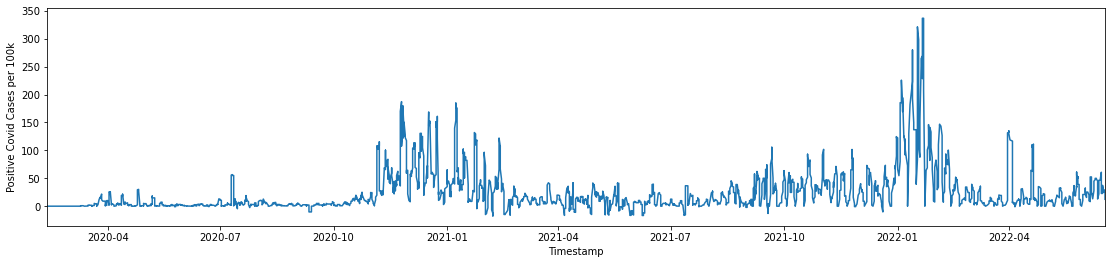

In [44]:
plt.plot(colorado.date, colorado.confirmed_numIncrease_per_100k_7dayRolling)
#plt.plot(minnesota.date, minnesota.confirmed_numIncrease_per_100k)
#plt.plot(louisiana.date, louisiana.confirmed_numIncrease_per_100k)
#plt.plot(washington.date, washington.confirmed_numIncrease_per_100k)
#plt.legend(loc='upper left')
#align the x-axis to read all labels
plt.gca().margins(x=0)
plt.gcf().canvas.draw()
tl = plt.gca().get_xticklabels()
maxsize = max([t.get_window_extent().width for t in tl])
m = 0.2 # inch margin
N = colorado.date.nunique() / 32
s = maxsize/plt.gcf().dpi*N+2*m
margin = m/plt.gcf().get_size_inches()[0]

plt.gcf().subplots_adjust(left=margin, right=1.-margin)
plt.gcf().set_size_inches(s, plt.gcf().get_size_inches()[1])

plt.ylabel('Positive Covid Cases per 100k')
plt.xlabel('Timestamp')
plt.show()

In [40]:
colorado.date.nunique()

844

In [41]:
rolling_1 = alt.Chart(colorado_noPadding).mark_line().encode(
    x='date:T',
    y='confirmed_numIncrease_per_100k_7dayRolling:Q'
).interactive()

In [42]:
nonrolling_2 = alt.Chart(colorado_noPadding).mark_line().encode(
    x='date:T',
    y='confirmed_numIncrease_per_100k:Q'
).interactive()

In [43]:
rolling_1 | nonrolling_2

alt.HConcatChart(...)